In [2]:
import os, sys
import pandas as pd
import json
import ast
import seaborn as sns
from cardano_explorer import blockfrost_api

# Import API Key from the config.py file in dev mode
path = '{}/{}'.format(os.path.dirname(os.path.abspath('..')), 'config.py')
if os.path.exists(path):
    sys.path.insert(0,'../..')
    import config
    blockfrost_api_key= config.blockfrost_api_key
    
# Seaborn configuration
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,8)})

### Update The Library 

### Set Blockfrost Api Key

In [3]:
cardano_mainnet = blockfrost_api.Auth(api_key=blockfrost_api_key)

### Get The Policy ID Of The CNFT Project

In [4]:
ada_ninjaz_policy_id = '83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3b8ec84d6fb'

### Check if all the assets have been minted 
8,888 CNFT have been minted for the first season of ADA Ninjaz. 

In [4]:
# Get the list of minted assets
cardano_mainnet.assets_policy(ada_ninjaz_policy_id, nb_of_results=None, pandas=True)

,asset,quantity
0,83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3...,1
1,83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3...,1
2,83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3...,1
3,83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3...,1
4,83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3...,1
...,...,...
8883,83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3...,1
8884,83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3...,1
8885,83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3...,1
8886,83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3...,1


### Get informations about the minted assets

In [5]:
#cn_assets_info = cardano_mainnet.assets_policy_info(ada_ninjaz_policy_id, nb_of_results=None, pandas=True)
#cn_assets_info.to_csv('../csv_files/brut_ada_ninjaz.csv', index=False)
#or
cn_assets_info = pd.read_csv('../csv_files/brut_ada_ninjaz.csv', sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '../csv_files/brut_ada_ninjaz.csv'

### Quick EDA (Exploratory Data Analysis)

In [79]:
# quick synthesis
print('Number of row       : ', ada_ninjaz_asset_info.shape[0])
print()
print('Number of columns   : ', ada_ninjaz_asset_info.shape[1])
print()
print('Features            : \n', ada_ninjaz_asset_info.columns.tolist())
print()
print('Missing values      : \n', ada_ninjaz_asset_info.isnull().sum())
print()
print('Total missing values:', ada_ninjaz_asset_info.isnull().values.sum())

Number of row       :  8888

Number of columns   :  30

Features            : 
 ['Unnamed: 0', 'asset', 'policy_id', 'asset_name', 'fingerprint', 'quantity', 'initial_mint_tx_hash', 'mint_or_burn_count', 'name', 'image', 'body', 'eyes', 'hair', 'mask', 'scar', 'files', 'mouth', 'glasses', 'weapons', 'clothing', 'earrings', 'nosering', 'companion', 'mediaType', 'background', 'facial_hair', 'hoskinanium', 'metadata', 'version', '83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3b8ec84d6fb']

Missing values      : 
 Unnamed: 0                                                     0
asset                                                          0
policy_id                                                      0
asset_name                                                     0
fingerprint                                                    0
quantity                                                       0
initial_mint_tx_hash                                           0
mint_or_burn_count            

## Pre Processing 

#### Create columns for the onchain metadata

In [80]:
# Create dataframe with the onchain metadata
ada_ninjaz_onchain_metadata = ada_ninjaz_asset_info['onchain_metadata'].apply(pd.Series)
onchain_metadata = ada_ninjaz_onchain_metadata.columns.tolist() 

# Add the onchain metadata to the assets dataframe
p_ada_ninjaz_asset_info = ada_ninjaz_asset_info.copy()
p_ada_ninjaz_asset_info[onchain_metadata] = ada_ninjaz_onchain_metadata

p_ada_ninjaz_asset_info.head(1)

KeyError: 'onchain_metadata'

#### Check if they are missing values in the onchain metadta

In [54]:
print('Missing values      : \n', p_ada_ninjaz_asset_info.isnull().sum())
print()
print('Total missing values:', p_ada_ninjaz_asset_info.isnull().values.sum())

Missing values      : 
 asset                                                         0
policy_id                                                     0
asset_name                                                    0
fingerprint                                                   0
quantity                                                      0
initial_mint_tx_hash                                          0
mint_or_burn_count                                            0
onchain_metadata                                              0
metadata                                                    100
name                                                          6
image                                                         6
body                                                          6
eyes                                                          6
hair                                                          6
mask                                                          6
scar            

#### Replace the missing

The missing data for the attributes are in the column name by the policy id **83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3b8ec84d6fb**

In [65]:
# Create dataframe with the missing onchain metadata
df_missing_assets = p_ada_ninjaz_asset_info[p_ada_ninjaz_asset_info.name.isnull()]

# Get the data to replace the missing onchain metadata
get_missing_assets_info = df_missing_assets[ada_ninjaz_policy_id].tolist()

# Create a DataFrame with onchain metadata to used to replace the missing data
df_onchain_metadata = pd.DataFrame.from_dict([list(name.values())[0] for name in get_missing_assets_info]).reset_index(drop=True)

# Replace the missing onchain metadata
df_available_data = df_missing_assets[[col_name for col_name in df_missing_assets.columns.tolist() if col_name not in df_onchain_metadata.columns.tolist()]].reset_index(drop=True).copy()
df_available_data[df_onchain_metadata.columns.tolist()] = df_onchain_metadata

# Reorder the column
df_available_data = df_available_data[p_ada_ninjaz_asset_info.columns.tolist()]

# Replace the row with the missing data
p_ada_ninjaz_asset_info = p_ada_ninjaz_asset_info.drop(labels=df_missing_assets.index.values, axis=0)
p_ada_ninjaz_asset_info = pd.concat([p_ada_ninjaz_asset_info, df_available_data])

# Del the row with policy id name 
p_ada_ninjaz_asset_info.drop(ada_ninjaz_policy_id, axis=1, inplace=True)

#p_ada_ninjaz_asset_info = p_ada_ninjaz_asset_info.replace('Ghoul Purple�', 'Ghoul Purple')
#p_ada_ninjaz_asset_info = p_ada_ninjaz_asset_info.replace('Oni Pink�', 'Oni Pink')

### Remove Unnecessary columns

In [66]:
unwanted_column = ['onchain_metadata', 'version', 'metadata'] 
p_ada_ninjaz_asset_info.drop(unwanted_column, axis=1, inplace=True)

In [69]:
# Verify if all the data have been replace 
print('Total missing values:', p_ada_ninjaz_asset_info.isnull().values.sum())

Total missing values: 0


## Attributes Statistics And Visualization 

body
Deep Brown      12
Golden Brown    23
Green            4
Honey Amber      9
Ivory           32
Pale             5
Porcelain       15
Name: quantity, dtype: int64

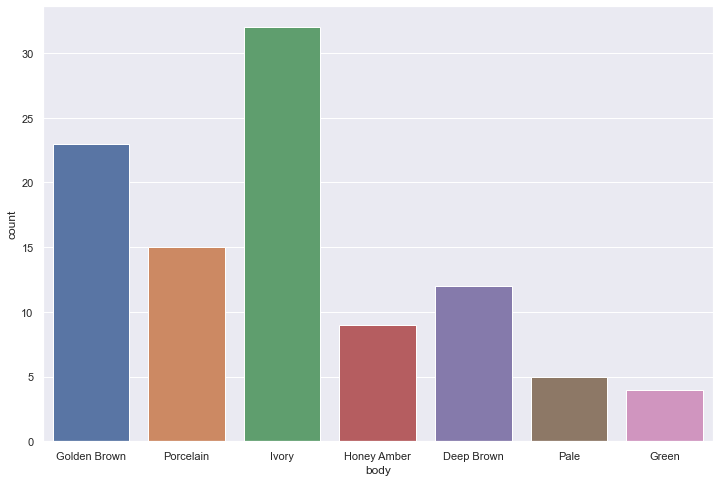

In [71]:
sns.countplot(x=p_ada_ninjaz_asset_info['body'])
p_ada_ninjaz_asset_info.groupby('body').count()['quantity']

eyes
Angry Orange             202
Angry Purple             109
Angry Red                156
Angry Teal               194
Angry Yellow             234
Closed                   195
Determined Blue          578
Determined Brown         569
Determined Orange        363
Determined Purple        628
Determined Red           611
Dizzy                     51
Focused Grey             533
Focused Orange           199
Focused Teal             430
One Brow Raised Blue     186
One Brow Raised Brown    317
One Brow Raised Green    206
Scared Green             246
Scared Grey              142
Scared Purple            200
Shocked                  238
Side Eyes Brown          201
Side Eyes Green          248
Side Eyes Orange         187
Squinting                219
Suspicious Blue          457
Suspicious Purple        144
Suspicious Yellow        214
Tired Grey               149
Tired Purple             276
Tired Red                206
Name: quantity, dtype: int64

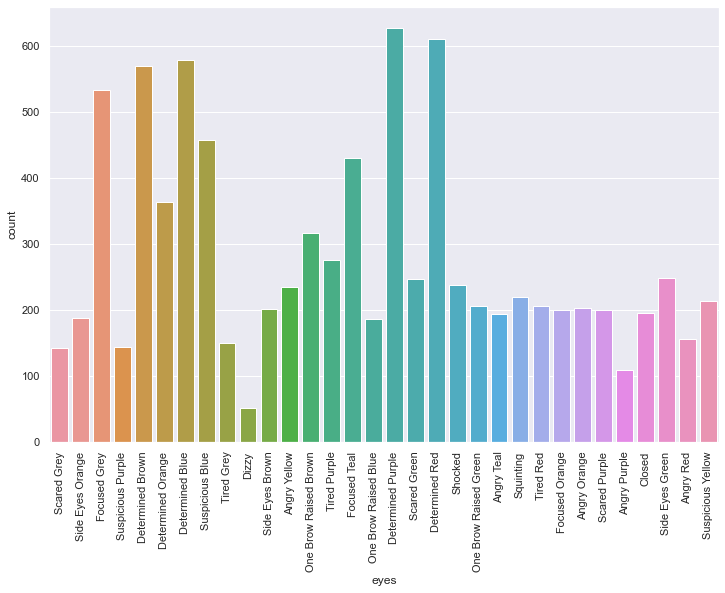

In [247]:
sns.countplot(x=p_ada_ninjaz_asset_info['eyes']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('eyes').count()['quantity']

hair
Afro Curls Blonde       84
Afro Curls Brown       111
Afro Curls Purple       85
Afro Full Blonde        50
Afro Full Blue          41
                      ... 
Undercut Slick Grey    177
Undercut Slick Pink    122
Wavy Spiky Brown       100
Wavy Spiky Green        75
Wavy Spiky Grey         93
Name: quantity, Length: 95, dtype: int64

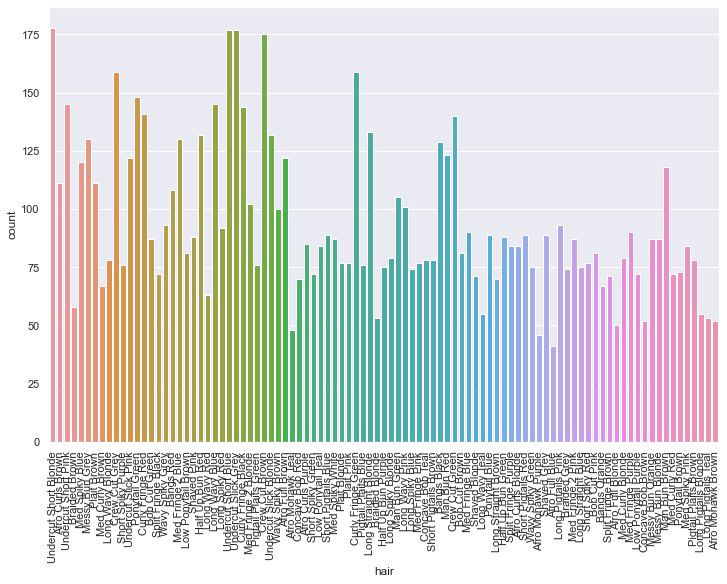

In [53]:
sns.countplot(x=p_ada_ninjaz_asset_info['hair']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('hair').count()['quantity']

mask
Angry React                  3
Demon Green                 29
Demon Grey                  27
Demon Pink                  31
Demon Red                   37
Demon Teal                  45
Dragon Bronze               36
Dragon Gold                 23
Dragon Green                37
Dragon Grey                 30
Dragon Purple               49
Futuristic Half Blue        44
Futuristic Half Green       31
Futuristic Half Purple      41
Futuristic Half Red         32
Futuristic Half Yellow      42
Ghoul Blue                  15
Ghoul Green                 35
Ghoul Purple                29
Ghoul Red                   19
Hoskinanium Ghoul            6
Hoskinanium Wolf            19
Kitsune Blue                29
Kitsune Green               38
Kitsune Orange              41
Kitsune Pink                34
Kitsune Yellow              27
None                      6782
Oni Blue                    24
Oni Green                   40
Oni Half Black              12
Oni Half Bronze             48
Oni

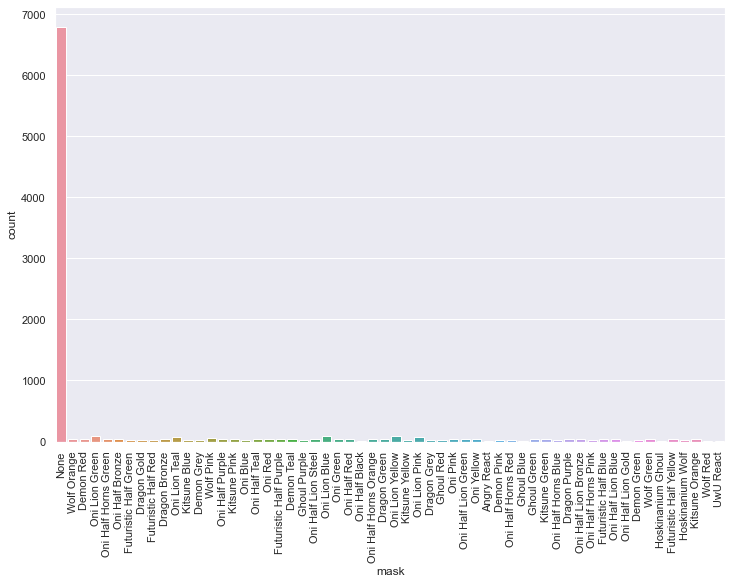

In [54]:
sns.countplot(x=p_ada_ninjaz_asset_info['mask']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('mask').count()['quantity']

mouth
Drool            97
Grin           1576
Grit            748
Jaw Drop        203
Neutral        1320
Open            322
Shout           847
Smile           363
Smirk          1004
Smirk Teeth    1305
Tasty           500
Tskk            603
Name: quantity, dtype: int64

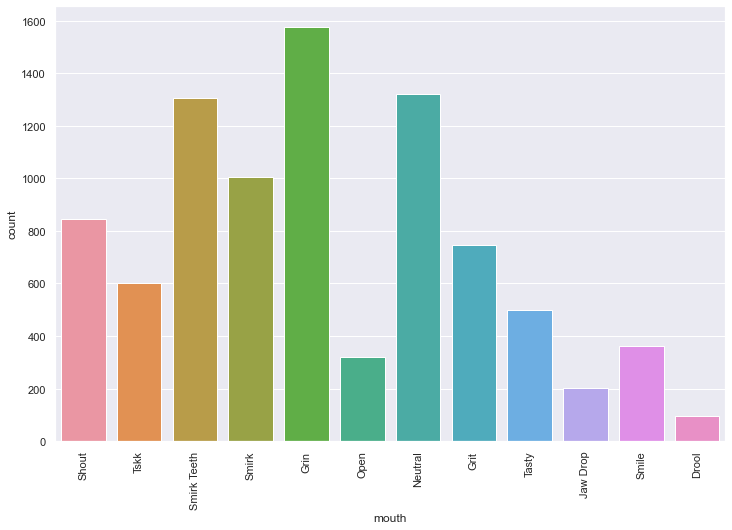

In [55]:
sns.countplot(x=p_ada_ninjaz_asset_info['mouth']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('mouth').count()['quantity']

glasses
Aviators Blue          52
Aviators Green         98
Aviators Pink          56
Aviators Red          141
Half Frame Blue       185
Half Frame Grey        64
Half Frame Orange      58
Half Frame Pink        77
Half Frame Red         67
None                 7250
Rectangle Brown        51
Rectangle Green        73
Rectangle Grey         54
Rectangle Purple       99
Rectangle Yellow       70
Reflection             27
Round Blue            101
Round Green           100
Round Red              70
Round Yellow           51
Wayfarer              144
Name: quantity, dtype: int64

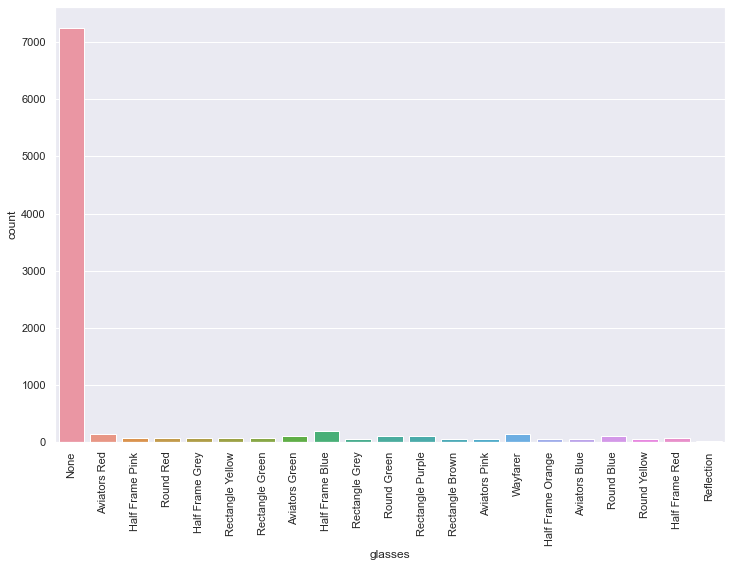

In [56]:
sns.countplot(x=p_ada_ninjaz_asset_info['glasses']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('glasses').count()['quantity']

weapons
8Bit Katana                52
Candy Katana               54
Chain Whip                111
Claws Gold                 27
Claws Steel               272
Dual Katana Blue          217
Dual Katana Gold           51
Dual Katana Orange        247
Dual Katana Purple        163
Dual Katana Red           199
Dual Katana Teal          225
Halbert                   190
Hoskinanium Kusarigama     57
Hoskinanium Shuriken      103
Hoskinanium Tonfa          59
Katana Blue               236
Katana Dragon Orange      176
Katana Dragon Pink        234
Katana Dragon Red         100
Katana Green              288
Katana Pink               292
Katana Purple             298
Katana Red                285
Katana White               79
Katana Yellow             235
Kendo Shinai              126
Kusarigama Orange         297
Kusarigama Pink           252
Mace                       81
Nunchaku                  125
Shuriken                  285
Steel Tonfa Pink          260
Steel Tonfa Yellow        284
St

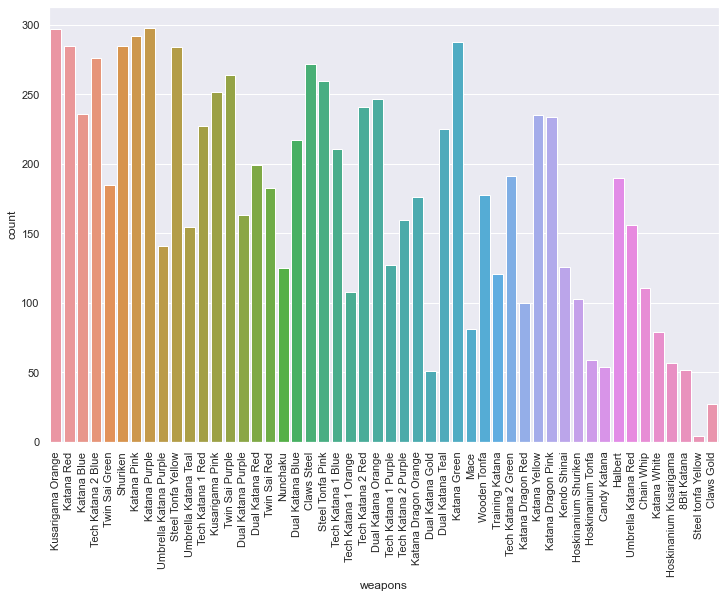

In [57]:
sns.countplot(x=p_ada_ninjaz_asset_info['weapons']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('weapons').count()['quantity']

clothing
Bomber Jacket Green    267
Bomber Jacket Navy     231
Bomber Jacket Red      184
Bum Bag Khaki           98
Bum Bag Red             97
                      ... 
Zip Shirt Black         47
Zip Shirt Blue         196
Zip Shirt Green        181
Zip Shirt Red           51
Zip Shirt red           49
Name: quantity, Length: 78, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


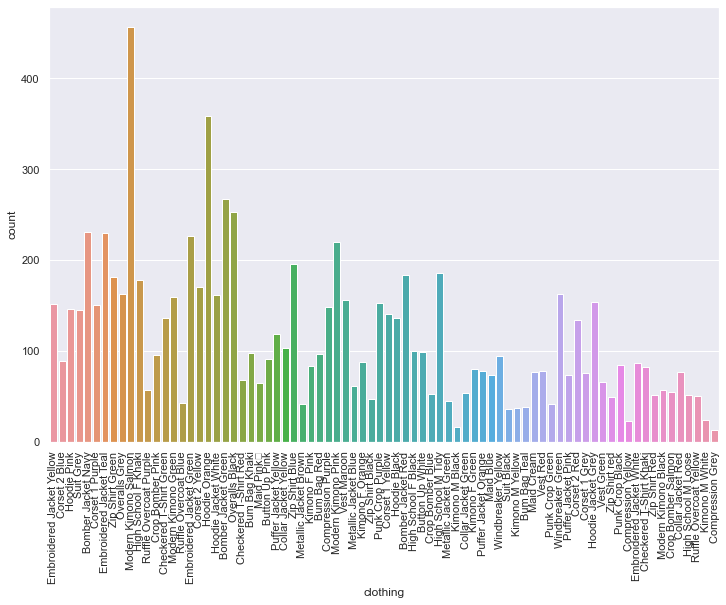

In [58]:
sns.countplot(x=p_ada_ninjaz_asset_info['clothing']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('clothing').count()['quantity']

earrings
Bear                82
Black Stud         502
Boba                80
Chain              130
Cross              150
Drop Pattern       179
Drop Rings         288
Drop Sunrise        58
Duck               102
Firecrackers       271
Katana             725
Kunai              751
Multiple Rings     357
None              2717
Ring               422
Shuriken           464
Soju                81
Star Stud          595
Triple Rings       934
Name: quantity, dtype: int64

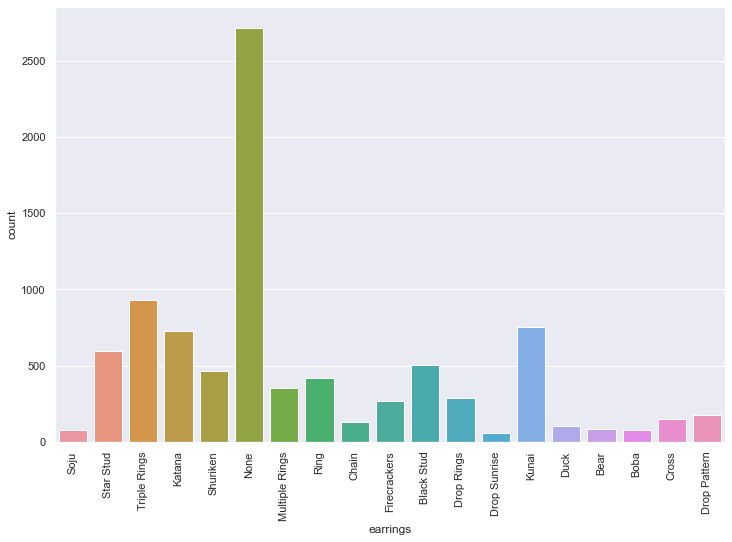

In [59]:
sns.countplot(x=p_ada_ninjaz_asset_info['earrings']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('earrings').count()['quantity']

nosering
None           6970
Ring            389
Septum Ring     875
Stud            654
Name: quantity, dtype: int64

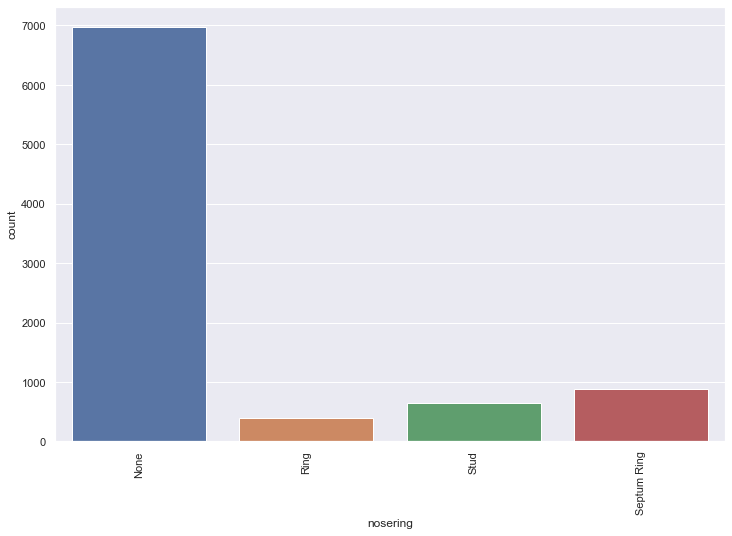

In [60]:
sns.countplot(x=p_ada_ninjaz_asset_info['nosering']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('nosering').count()['quantity']

companion
Ajax Green             43
Ajax Purple            52
Ajax Red               72
Ajax Steel             49
Ajax Yellow            63
Finn Blue              37
Finn Green            102
Finn Pink             148
Finn Red               47
Finn Steel             23
Finn Yellow            63
Hoskinanium Shion      10
Nima Blue              73
Nima Green             19
Nima Orange            16
Nima Pink              25
Nima Purple           120
Nima Teal              60
None                 7062
Scout Green           112
Scout Pink             89
Scout Purple           56
Scout Red�             37
Scout Teal             49
Scout Yellow           42
Shion Green           105
Shion Orange           89
Shion Pink             77
Shion Red              48
Shion Teal            100
Name: quantity, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


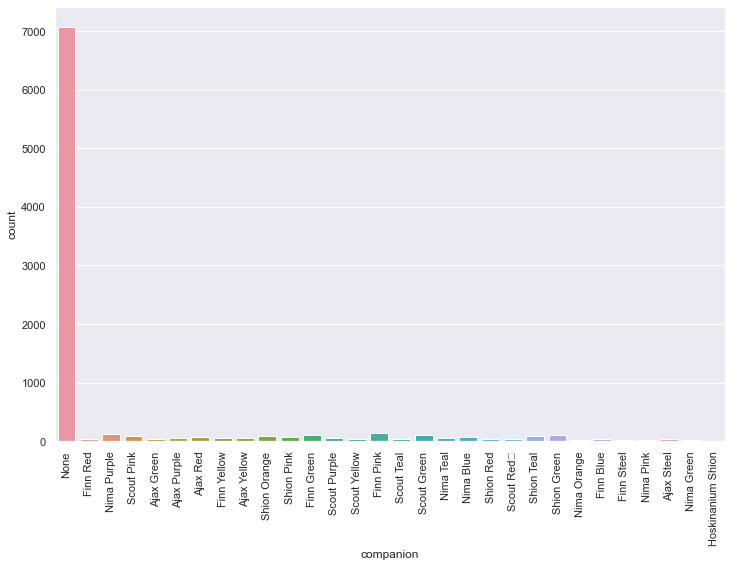

In [61]:
sns.countplot(x=p_ada_ninjaz_asset_info['companion']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('companion').count()['quantity']

background
Blood Splatter Blue        92
Blood Splatter Pink        91
Blood Splatter Red         60
City Purple                87
City Red                   88
City Yellow                60
Inner Clouds Blue          80
Inner Clouds Cream         88
Inner Clouds Pink          84
Lantern Blue               81
Lantern Pink              101
Lotus Blue                 84
Lotus Pink                136
Manga Action Blue         116
Manga Action Pink         127
Manga Action Purple       105
Manga Action Red           57
Manga Action Yellow        90
Manga Swirl Blue           57
Manga Vertical Purple�    120
Outer Clouds Blue          89
Outer Clouds Navy         100
Outer Clouds Purple       125
Petals Navy Brown          60
Petals Pink Yellow         85
Sakura Tree Cream          65
Sakura Tree Lavender       26
Sakura Tree Salmon         75
Shrine                     97
Smoke Bomb Blue           129
Smoke Bomb Cream          159
Smoke Bomb Green          162
Smoke Bomb Grey            66

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


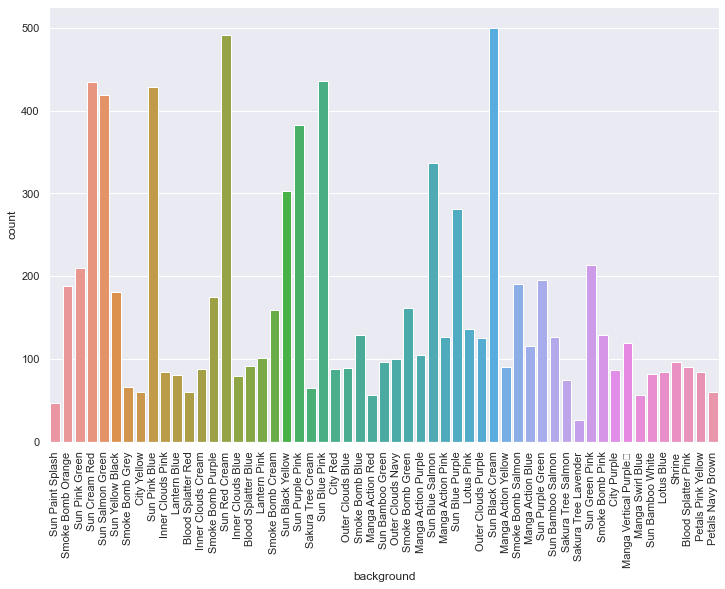

In [62]:
sns.countplot(x=p_ada_ninjaz_asset_info['background']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('background').count()['quantity']

facial_hair
Goatee           882
Mustache         411
None            6897
Shaved Beard     698
Name: quantity, dtype: int64

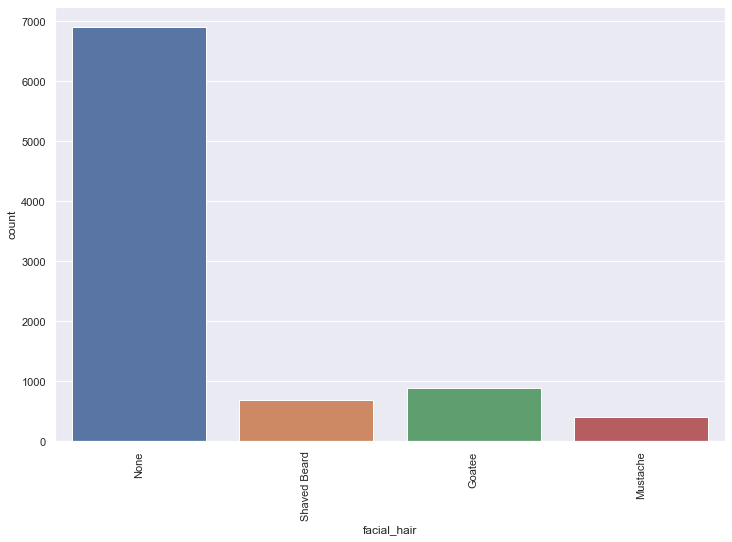

In [63]:
sns.countplot(x=p_ada_ninjaz_asset_info['facial_hair']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('facial_hair').count()['quantity']

hoskinanium
Energy                          175
None                           8708
Spirit Guardian Anaisthitos       1
Spirit Guardian Ekkono            1
Spirit Guardian Holos             1
Spirit Guardian Jivashastra       1
Spirit Guardian Mores             1
Name: quantity, dtype: int64

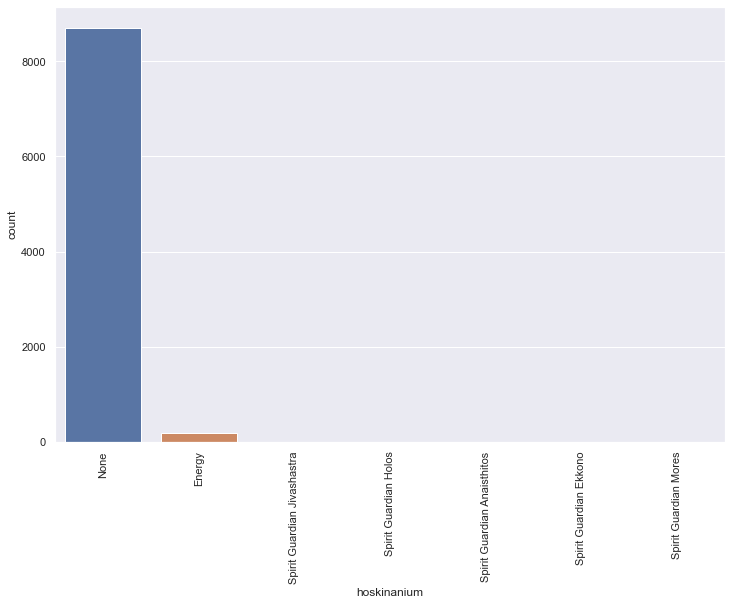

In [64]:
sns.countplot(x=p_ada_ninjaz_asset_info['hoskinanium']).tick_params(axis='x', rotation=90)
p_ada_ninjaz_asset_info.groupby('hoskinanium').count()['quantity']

## Create Rarity Coeff And Ranking

In [66]:
def attr_freq_in_percent(attr_value_count):
    '''Calculate the frequency of the attribute in percentage'''
    percentage = (100 * attr_value_count) / nb_of_assets
    return round(percentage, 2)

def rarity_insights(attribute_name, attr_freq_count, attr_freq_perc):
    '''Add insights to the assest attribute'''
    return '{}: {} / {} ({}%)'.format(attribute_name, attr_freq_count, nb_of_assets, attr_freq_perc)

# ADA Ninjaz attributes
attributes = ['body', 'eyes', 'hair', 'mask', 'scar', 'mouth',
              'glasses', 'weapons', 'clothing', 'earrings', 'nosering',
              'companion', 'background', 'facial_hair', 'hoskinanium' ]

# Create a new dataframe
ranking_ada_ninjaz = p_ada_ninjaz_asset_info.copy()

# Total of assets minted 
nb_of_assets = len(ranking_ada_ninjaz)

# Create column with rarity indicators for each attribute
for attribute in attributes:
    
    # New column names to add to the dataframe
    freq_count_col_name = "{}_freq_count".format(attribute)
    freq_pct_col_name = "{}_freq_pct".format(attribute)
    ration_col_name = "{}_ratio".format(attribute)
    
    # Count the frequency of the attribute
    ranking_ada_ninjaz[freq_count_col_name] = ranking_ada_ninjaz.groupby(attribute)[attribute].transform('count').tolist()
    
    # Calculate the frequency of the attribute in percentage 
    attr_freq_pct = ranking_ada_ninjaz[freq_count_col_name].apply(attr_freq_in_percent)
    ranking_ada_ninjaz[freq_pct_col_name] = attr_freq_pct 
    
    # Calculate the ration of each attribute
    ranking_ada_ninjaz[ration_col_name] = round(attr_freq_pct / 100, 4)

# Add a column with the sum of the ration of each attribute of each assets
ranking_ada_ninjaz['sum_ratio_attr'] = ranking_ada_ninjaz[[column_name for column_name in ranking_ada_ninjaz.columns if 'ratio' in column_name]].sum(axis = 1)

# Add the rarity insights for each attribute of each assets
ranking_ada_ninjaz['body'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.body, x.body_freq_count, x.body_freq_pct), axis=1)
ranking_ada_ninjaz['eyes'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.eyes, x.eyes_freq_count, x.eyes_freq_pct), axis=1)
ranking_ada_ninjaz['hair'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.hair, x.hair_freq_count, x.hair_freq_pct), axis=1)
ranking_ada_ninjaz['mask'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.mask, x.mask_freq_count, x.mask_freq_pct), axis=1)
ranking_ada_ninjaz['scar'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.scar, x.scar_freq_count, x.scar_freq_pct), axis=1)
ranking_ada_ninjaz['mouth'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.mouth, x.mouth_freq_count, x.mouth_freq_pct), axis=1)
ranking_ada_ninjaz['glasses'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.glasses, x.glasses_freq_count, x.glasses_freq_pct), axis=1)
ranking_ada_ninjaz['weapons'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.weapons, x.weapons_freq_count, x.weapons_freq_pct), axis=1)
ranking_ada_ninjaz['clothing'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.clothing, x.clothing_freq_count, x.clothing_freq_pct), axis=1)
ranking_ada_ninjaz['earrings'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.earrings, x.earrings_freq_count, x.earrings_freq_pct), axis=1)
ranking_ada_ninjaz['nosering'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.nosering, x.nosering_freq_count, x.nosering_freq_pct), axis=1)
ranking_ada_ninjaz['companion'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.companion, x.companion_freq_count, x.companion_freq_pct), axis=1)
ranking_ada_ninjaz['background'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.background, x.background_freq_count, x.background_freq_pct), axis=1)
ranking_ada_ninjaz['facial_hair'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.facial_hair, x.facial_hair_freq_count, x.facial_hair_freq_pct), axis=1)
ranking_ada_ninjaz['hoskinanium'] = ranking_ada_ninjaz.apply(lambda x: rarity_insights(x.hoskinanium, x.hoskinanium_freq_count, x.hoskinanium_freq_pct), axis=1)


In [93]:
# Ascending sort the column with the ratio for determinated the ranking
ranking_ada_ninjaz = ranking_ada_ninjaz.sort_values(by=['sum_ratio_attr'])

# Add a column with the ranking number
ranking_ada_ninjaz['ranking'] = ['#{}'.format(i) for i in range(1, nb_of_assets+1)]

wanted_columns = ['name', 'ranking'] + attributes

#Show the top 10
ranking_ada_ninjaz[wanted_columns + attributes].head(10)

In [94]:
ranking_ada_ninjaz[wanted_columns + attributes].head(10)

,name,ranking,body,eyes,hair,mask,scar,mouth,glasses,weapons,...,mouth,glasses,weapons,clothing,earrings,nosering,companion,background,facial_hair,hoskinanium
2656,ADA Ninjaz - Aramar #3594,#1,Deep Brown: 1086 / 8888 (12.22%),Suspicious Blue: 457 / 8888 (5.14%),Afro Full Blonde: 50 / 8888 (0.56%),<bound method Series.mask of asset ...,Single: 201 / 8888 (2.26%),Smile: 363 / 8888 (4.08%),Half Frame Blue: 185 / 8888 (2.08%),8Bit Katana: 52 / 8888 (0.59%),...,Smile: 363 / 8888 (4.08%),Half Frame Blue: 185 / 8888 (2.08%),8Bit Katana: 52 / 8888 (0.59%),Button Up White: 99 / 8888 (1.11%),Drop Rings: 288 / 8888 (3.24%),None: 6970 / 8888 (78.42%),Finn Green: 102 / 8888 (1.15%),City Yellow: 60 / 8888 (0.68%),Shaved Beard: 698 / 8888 (7.85%),None: 8708 / 8888 (97.97%)
8553,ADA Ninjaz - Aramar #5779,#2,Ivory: 2645 / 8888 (29.76%),Suspicious Yellow: 214 / 8888 (2.41%),Pigtail Plaits Blue: 76 / 8888 (0.86%),<bound method Series.mask of asset ...,Single: 201 / 8888 (2.26%),Grit: 748 / 8888 (8.42%),None: 7250 / 8888 (81.57%),Tech Katana 1 Blue: 211 / 8888 (2.37%),...,Grit: 748 / 8888 (8.42%),None: 7250 / 8888 (81.57%),Tech Katana 1 Blue: 211 / 8888 (2.37%),Compression Purple: 148 / 8888 (1.67%),Ring: 422 / 8888 (4.75%),Stud: 654 / 8888 (7.36%),Shion Teal: 100 / 8888 (1.13%),Sun Black Cream: 500 / 8888 (5.63%),None: 6897 / 8888 (77.6%),Energy: 175 / 8888 (1.97%)
4725,ADA Ninjaz - Aramar #4479,#3,Ivory: 2645 / 8888 (29.76%),Tired Grey: 149 / 8888 (1.68%),Messy Bun Blonde: 87 / 8888 (0.98%),<bound method Series.mask of asset ...,Triple: 240 / 8888 (2.7%),Grit: 748 / 8888 (8.42%),Wayfarer: 144 / 8888 (1.62%),Umbrella Katana Teal: 155 / 8888 (1.74%),...,Grit: 748 / 8888 (8.42%),Wayfarer: 144 / 8888 (1.62%),Umbrella Katana Teal: 155 / 8888 (1.74%),Corset 1 Grey: 76 / 8888 (0.86%),Katana: 725 / 8888 (8.16%),Septum Ring: 875 / 8888 (9.84%),Scout Teal: 49 / 8888 (0.55%),Sun Yellow Black: 181 / 8888 (2.04%),None: 6897 / 8888 (77.6%),None: 8708 / 8888 (97.97%)
4116,ADA Ninjaz - Aramar #7690,#4,Deep Brown: 1086 / 8888 (12.22%),Side Eyes Green: 248 / 8888 (2.79%),Undercut Short Pink: 145 / 8888 (1.63%),<bound method Series.mask of asset ...,Cross: 198 / 8888 (2.23%),Neutral: 1320 / 8888 (14.85%),Round Blue: 101 / 8888 (1.14%),Katana Dragon Pink: 234 / 8888 (2.63%),...,Neutral: 1320 / 8888 (14.85%),Round Blue: 101 / 8888 (1.14%),Katana Dragon Pink: 234 / 8888 (2.63%),Collar Jacket Yellow: 103 / 8888 (1.16%),Firecrackers: 271 / 8888 (3.05%),None: 6970 / 8888 (78.42%),None: 7062 / 8888 (79.46%),Blood Splatter Blue: 92 / 8888 (1.04%),None: 6897 / 8888 (77.6%),Energy: 175 / 8888 (1.97%)
106,ADA Ninjaz - Aramar #6889,#5,Green: 678 / 8888 (7.63%),Side Eyes Brown: 201 / 8888 (2.26%),Man Bun Red: 123 / 8888 (1.38%),<bound method Series.mask of asset ...,None: 7852 / 8888 (88.34%),Shout: 847 / 8888 (9.53%),Aviators Red: 141 / 8888 (1.59%),Hoskinanium Tonfa: 59 / 8888 (0.66%),...,Shout: 847 / 8888 (9.53%),Aviators Red: 141 / 8888 (1.59%),Hoskinanium Tonfa: 59 / 8888 (0.66%),Embroidered Jacket Yellow: 152 / 8888 (1.71%),Black Stud: 502 / 8888 (5.65%),None: 6970 / 8888 (78.42%),None: 7062 / 8888 (79.46%),Sun Purple Pink: 383 / 8888 (4.31%),Shaved Beard: 698 / 8888 (7.85%),Energy: 175 / 8888 (1.97%)
380,ADA Ninjaz - Aramar #6038,#6,Pale: 710 / 8888 (7.99%),Angry Orange: 202 / 8888 (2.27%),Undercut Short Blonde: 178 / 8888 (2.0%),<bound method Series.mask of asset ...,Cross: 198 / 8888 (2.23%),Grit: 748 / 8888 (8.42%),Round Green: 100 / 8888 (1.13%),Tech Katana 2 Purple: 160 / 8888 (1.8%),...,Grit: 748 / 8888 (8.42%),Round Green: 100 / 8888 (1.13%),Tech Katana 2 Purple: 160 / 8888 (1.8%),Corset 1 Yellow: 140 / 8888 (1.58%),Drop Rings: 288 / 8888 (3.24%),Stud: 654 / 8888 (7.36%),Finn Blue: 37 / 8888 (0.42%),Smoke Bomb Salmon: 191 / 8888 (2.15%),None: 6897 / 8888 (77.6%),None: 8708 / 8888 (97.97%)
4408,ADA Ninjaz - Aramar #1741,#7,Porcelain: 1538 / 8888 (17.3%),Side Eyes Brown: 201 / 8888 (2.26%),Afro Curls Brown: 111 / 8888 (1.25%),<bound method Series.mask of asset ...

In [95]:
5238

5238

In [106]:
ranking_ada_ninjaz[wanted_columns + attributes ][ranking_ada_ninjaz.name.str.contains('#7115')]

,name,ranking,body,eyes,hair,mask,scar,mouth,glasses,weapons,...,mouth,glasses,weapons,clothing,earrings,nosering,companion,background,facial_hair,hoskinanium
8544,ADA Ninjaz - Aramar #7115,#1914,Ivory: 2645 / 8888 (29.76%),Tired Purple: 276 / 8888 (3.11%),Long Wavy Red: 63 / 8888 (0.71%),<bound method Series.mask of asset ...,None: 7852 / 8888 (88.34%),Shout: 847 / 8888 (9.53%),Half Frame Red: 67 / 8888 (0.75%),Dual Katana Red: 199 / 8888 (2.24%),...,Shout: 847 / 8888 (9.53%),Half Frame Red: 67 / 8888 (0.75%),Dual Katana Red: 199 / 8888 (2.24%),Overalls Grey: 162 / 8888 (1.82%),Triple Rings: 934 / 8888 (10.51%),None: 6970 / 8888 (78.42%),Shion Red: 48 / 8888 (0.54%),Sun Salmon Green: 419 / 8888 (4.71%),None: 6897 / 8888 (77.6%),None: 8708 / 8888 (97.97%)


In [102]:
cardano_mainnet.specific_asset(ada_ninjaz_policy_id+ '4164614e696e6a617a33343032')

{'asset': '83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3b8ec84d6fb4164614e696e6a617a33343032',
 'policy_id': '83c0ab67afc9148bd1571b7a14de1df03cd5624f5992d3b8ec84d6fb',
 'asset_name': '4164614e696e6a617a33343032',
 'fingerprint': 'asset1rwyq5a077wleaykezcn5u6xc8t7cftc4mgfje4',
 'quantity': '1',
 'initial_mint_tx_hash': 'f64d4959560cf8468485dda14c7465b0b1248ab6ce2ba2485af31cdf5f63cd52',
 'mint_or_burn_count': 1,
 'onchain_metadata': {'name': 'ADA Ninjaz - Aramar #3402',
  'image': 'ipfs://QmZKoyVwQocwE3AzG9rakqJgBz9nQ4xNBrK5exBMCrmU4Z',
  'body': 'Green',
  'eyes': 'Angry Orange',
  'hair': 'Med Fringe 2 Blue',
  'mask': 'None',
  'scar': 'None',
  'files': [{'src': 'ipfs://QmZKoyVwQocwE3AzG9rakqJgBz9nQ4xNBrK5exBMCrmU4Z',
    'name': 'ADA Ninjaz - Aramar #3402',
    'mediaType': 'image/png'}],
  'mouth': 'Jaw Drop',
  'glasses': 'None',
  'weapons': 'Dual Katana Blue',
  'clothing': 'Button Up Pink',
  'earrings': 'Katana',
  'nosering': 'None',
  'companion': 'None',
  'mediaType': 'i